<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/3_Clasificacion/6_CVClasificacion_LFW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase - comparación de métodos utilizando validación cruzada

- Se presenta un esquema completo de comparación de clasifacadores en la base de datos People Labaled Faces in the Wild, aka [LFW](Labeled Faces in the Wild).

- Además, se plantean algunos ejercicios teórico-prácticos relacionados con tareas de clasificación utilizando aprendizaje de máquina clásico.

**Nota**: Es importante tener en cuenta que los resultados de comparación incluyen promediados simples, sopesados en términos de la probabilidad marginal de cada clase, además de promediados [micro y macro](https://androidkt.com/micro-macro-averages-for-imbalance-multiclass-classification/).

- Se plantean algunas funciones para el cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [1]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path) 
    
import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):   
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()

    
#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

    
# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes
    
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        if normalize:
            title = 'Matriz de confusión normalizada'
        else:
            title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


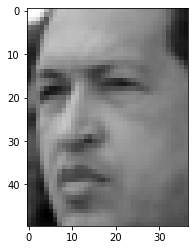

In [2]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[0,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

# HoldOut evaluación

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluación.

In [3]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3) 
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
1080,0.124183,0.158170,0.252288,0.390850,0.448366,0.414379,0.376471,0.356863,0.390850,0.416993,0.411765,0.427451,0.471895,0.491503,0.504575,0.499346,0.487582,0.492810,0.512418,0.526797,0.533333,0.541176,0.543791,0.534640,0.508497,0.483660,0.471895,0.457516,0.447059,0.443137,0.428758,0.416993,0.402614,0.358170,0.196078,0.090196,0.086275,0.135948,0.236601,0.356863,...,0.772549,0.337255,0.115033,0.082353,0.115033,0.467974,0.884967,0.930719,0.916340,0.908497,0.832680,0.601307,0.496732,0.469281,0.460131,0.460131,0.461438,0.443137,0.420915,0.397386,0.379085,0.372549,0.400000,0.413072,0.419608,0.431373,0.453595,0.482353,0.490196,0.491503,0.484967,0.487582,0.509804,0.606536,0.771242,0.881046,0.867974,0.818301,0.447059,0.113725
826,0.284967,0.352941,0.461438,0.431373,0.467974,0.674510,0.743791,0.758170,0.792157,0.792157,0.759477,0.743791,0.726797,0.730719,0.728105,0.718954,0.711111,0.711111,0.709804,0.704575,0.684967,0.682353,0.671895,0.664052,0.662745,0.649673,0.639216,0.624837,0.610458,0.593464,0.569935,0.522876,0.448366,0.411765,0.389542,0.373856,0.381699,0.257516,0.368627,0.501961,...,0.888889,0.890196,0.879739,0.138562,0.118954,0.116340,0.141176,0.160784,0.190850,0.228758,0.180392,0.130719,0.322876,0.749020,0.545098,0.517647,0.435294,0.368627,0.342484,0.338562,0.354248,0.363399,0.366013,0.367320,0.373856,0.371242,0.379085,0.407843,0.424837,0.432680,0.469281,0.492810,0.521569,0.681046,0.836601,0.874510,0.881046,0.888889,0.883660,0.813072
285,0.469281,0.426144,0.372549,0.477124,0.588235,0.650980,0.716340,0.756863,0.790850,0.819608,0.824837,0.827451,0.827451,0.839216,0.849673,0.848366,0.849673,0.844444,0.831373,0.843137,0.826144,0.798693,0.790850,0.790850,0.796078,0.824837,0.874510,0.913725,0.835294,0.729412,0.484967,0.458824,0.669281,0.776471,0.794771,0.784314,0.674510,0.454902,0.400000,0.396078,...,0.287582,0.294118,0.299346,0.169935,0.172549,0.176471,0.181699,0.177778,0.194771,0.525490,0.542484,0.496732,0.458824,0.343791,0.222222,0.249673,0.269281,0.257516,0.266667,0.265359,0.266667,0.278431,0.270588,0.270588,0.260131,0.277124,0.281046,0.244444,0.190850,0.150327,0.181699,0.156863,0.084967,0.205229,0.260131,0.274510,0.275817,0.279739,0.286275,0.295425
948,0.500654,0.488889,0.507190,0.524183,0.526797,0.520261,0.525490,0.533333,0.541176,0.546405,0.550327,0.552941,0.556863,0.552941,0.547712,0.571242,0.572549,0.567320,0.580392,0.616993,0.660131,0.695425,0.709804,0.751634,0.827451,0.873203,0.883660,0.892810,0.896732,0.844444,0.607843,0.231373,0.069281,0.067974,0.067974,0.071895,0.078431,0.500654,0.490196,0.495425,...,0.518954,0.416993,0.322876,0.418301,0.448366,0.435294,0.372549,0.329412,0.316340,0.329412,0.343791,0.342484,0.338562,0.343791,0.339869,0.338562,0.345098,0.356863,0.371242,0.383007,0.411765,0.443137,0.471895,0.505882,0.513726,0.547712,0.627451,0.648366,0.538562,0.373856,0.322876,0.400000,0.525490,0.658824,0.708497,0.690196,0.624837,0.533333,0.435294,0.333333
1248,0.643137,0.636601,0.636601,0.633987,0.662745,0.691503,0.703268,0.717647,0.738562,0.759477,0.756863,0.771242,0.766013,0.773856,0.792157,0.788235,0.767320,0.739869,0.712418,0.684967,0.678431,0.669281,0.654902,0.639216,0.605229,0.579085,0.569935,0.555556,0.532026,0.528105,0.541176,0.640523,0.772549,0.797386,0.709804,0.470588,0.375163,0.615686,0.616993,0.632680,...,0.070588,0.069281,0.060131,0.064052,0.066667,0.070588,0.070588,0.260131,0.760784,0.903268,0.941176,0.843137,0.522876,0.363399,0.363399,0.349020,0.300654,0.301961,0.324183,0.352941,0.350327,0.333333,0.332026,0.329412,0.330719,0.315033,0.303268,0.304575,0.313726,0.287582,0.295425,0.478431,0.758170,0.915033,0.883660,0.728105,0.304575,0.074510,0.066667,0.060131


# Búsqueda de parámetros utilizando gridsearchCV



In [4]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]
       
parameters = [{              
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline2 - hyperparametros 
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   28.7s finished


modelo 2/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    9.4s finished


modelo 3/3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  3.4min finished


# Rendimientos utilizando validación cruzada (conjuntos entrenamiento y validación)

- Se muestran los resultados de la validación cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificación ver 

**Nota**: el argumento `refit=True` en GridsearchCV se aseguro de reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

In [5]:
ind = models[2].cv_results_['mean_test_score'].argmax()
models[i].cv_results_['mean_test_score'][i]


0.42729895641497856

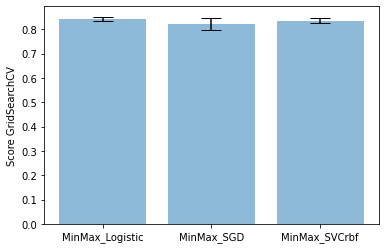

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
[[0.844 0.822 0.836]
 [0.008 0.026 0.01 ]]


In [6]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

# Calcular rendimiento en cojunto de test

- En caso práctico y buscando cuantificar la generalización de los modelos, se cálcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusión y se utiliza el método [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

Evaluando modelo MinMax_Logistic (1/3)


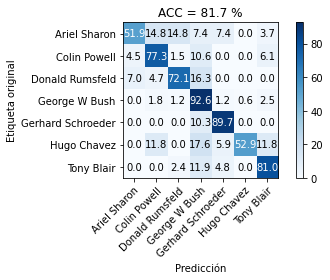

                   precision    recall  f1-score   support

     Ariel Sharon       0.70      0.52      0.60        27
     Colin Powell       0.82      0.77      0.80        66
  Donald Rumsfeld       0.79      0.72      0.76        43
    George W Bush       0.85      0.93      0.89       163
Gerhard Schroeder       0.79      0.90      0.84        29
      Hugo Chavez       0.90      0.53      0.67        17
       Tony Blair       0.76      0.81      0.78        42

         accuracy                           0.82       387
        macro avg       0.80      0.74      0.76       387
     weighted avg       0.82      0.82      0.81       387

Evaluando modelo MinMax_SGD (2/3)


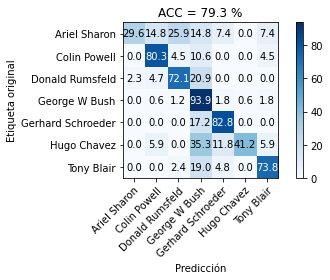

                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.30      0.44        27
     Colin Powell       0.87      0.80      0.83        66
  Donald Rumsfeld       0.70      0.72      0.71        43
    George W Bush       0.80      0.94      0.86       163
Gerhard Schroeder       0.73      0.83      0.77        29
      Hugo Chavez       0.88      0.41      0.56        17
       Tony Blair       0.78      0.74      0.76        42

         accuracy                           0.79       387
        macro avg       0.81      0.68      0.71       387
     weighted avg       0.80      0.79      0.78       387

Evaluando modelo MinMax_SVCrbf (3/3)


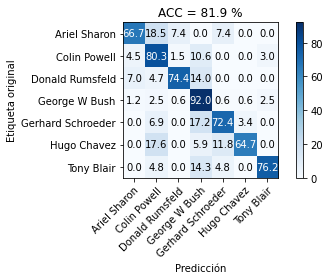

                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.67      0.68        27
     Colin Powell       0.75      0.80      0.77        66
  Donald Rumsfeld       0.89      0.74      0.81        43
    George W Bush       0.86      0.92      0.89       163
Gerhard Schroeder       0.75      0.72      0.74        29
      Hugo Chavez       0.85      0.65      0.73        17
       Tony Blair       0.84      0.76      0.80        42

         accuracy                           0.82       387
        macro avg       0.80      0.75      0.77       387
     weighted avg       0.82      0.82      0.82       387



In [7]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)
     
    plot_confusion_matrix(
                          ytest, ytest_e, 
                          classes=lfw_people.target_names,
                          normalize=True,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])                      
    plt.show()
    
    cr = classification_report(
                               ytest, ytest_e, 
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )                          
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la líne de código donde se cálcula el score de predicción en términos de la función de decisión o la probilidad de detección según el tipo de modelo. 

Por ejemplo: la  [´SVC´](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el método decision function, el [´KnearestNeighborsClassifier´](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el método predict proba.

Evaluando modelo MinMax_Logistic (1/3)


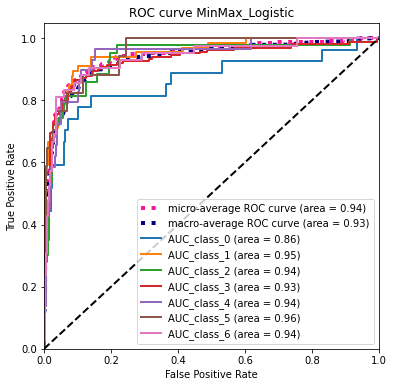

Evaluando modelo MinMax_SGD (2/3)


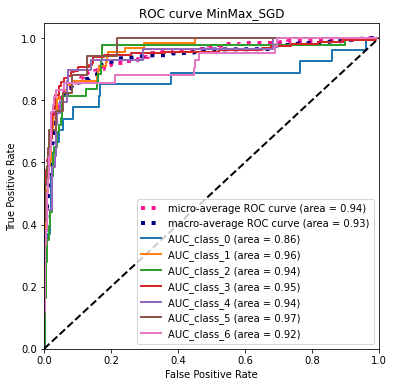

Evaluando modelo MinMax_SVCrbf (3/3)


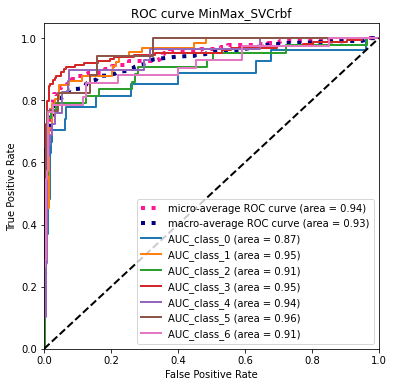

In [8]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
    #debe calcularse la funcion de decision o el posterior de la probabilidad
    ytest_score = my_model_loaded[i].decision_function(Xtest) 
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)
    

# Ejercicio

1. Consulte y presente el modelo y problema de optimización de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)